# Import needed modules

In [3]:
# !pip install tensorflow==2.9.1

In [4]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [6]:
# Generate data paths with labels
data_dir = '/content/drive/MyDrive/MLDP/mango-leaf-disease-dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
df

,filepaths,labels
0,/content/drive/MyDrive/MLDP/mango-leaf-disease...,Healthy
1,/content/drive/MyDrive/MLDP/mango-leaf-disease...,Healthy
2,/content/drive/MyDrive/MLDP/mango-leaf-disease...,Healthy
3,/content/drive/MyDrive/MLDP/mango-leaf-disease...,Healthy
4,/content/drive/MyDrive/MLDP/mango-leaf-disease...,Healthy
...,...,...
3995,/content/drive/MyDrive/MLDP/mango-leaf-disease...,Powdery Mildew
3996,/content/drive/MyDrive/MLDP/mango-leaf-disease...,Powdery Mildew
3997,/content/drive/MyDrive/MLDP/mango-leaf-disease...,Powdery Mildew
3998,/content/drive/MyDrive/MLDP/mango-leaf-disease...,Powdery Mildew


### **Split dataframe into train, valid, and test**

In [8]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **Create image data generator**

In [9]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 3200 validated image filenames belonging to 8 classes.
Found 480 validated image filenames belonging to 8 classes.
Found 320 validated image filenames belonging to 8 classes.


### **Show sample from train data**

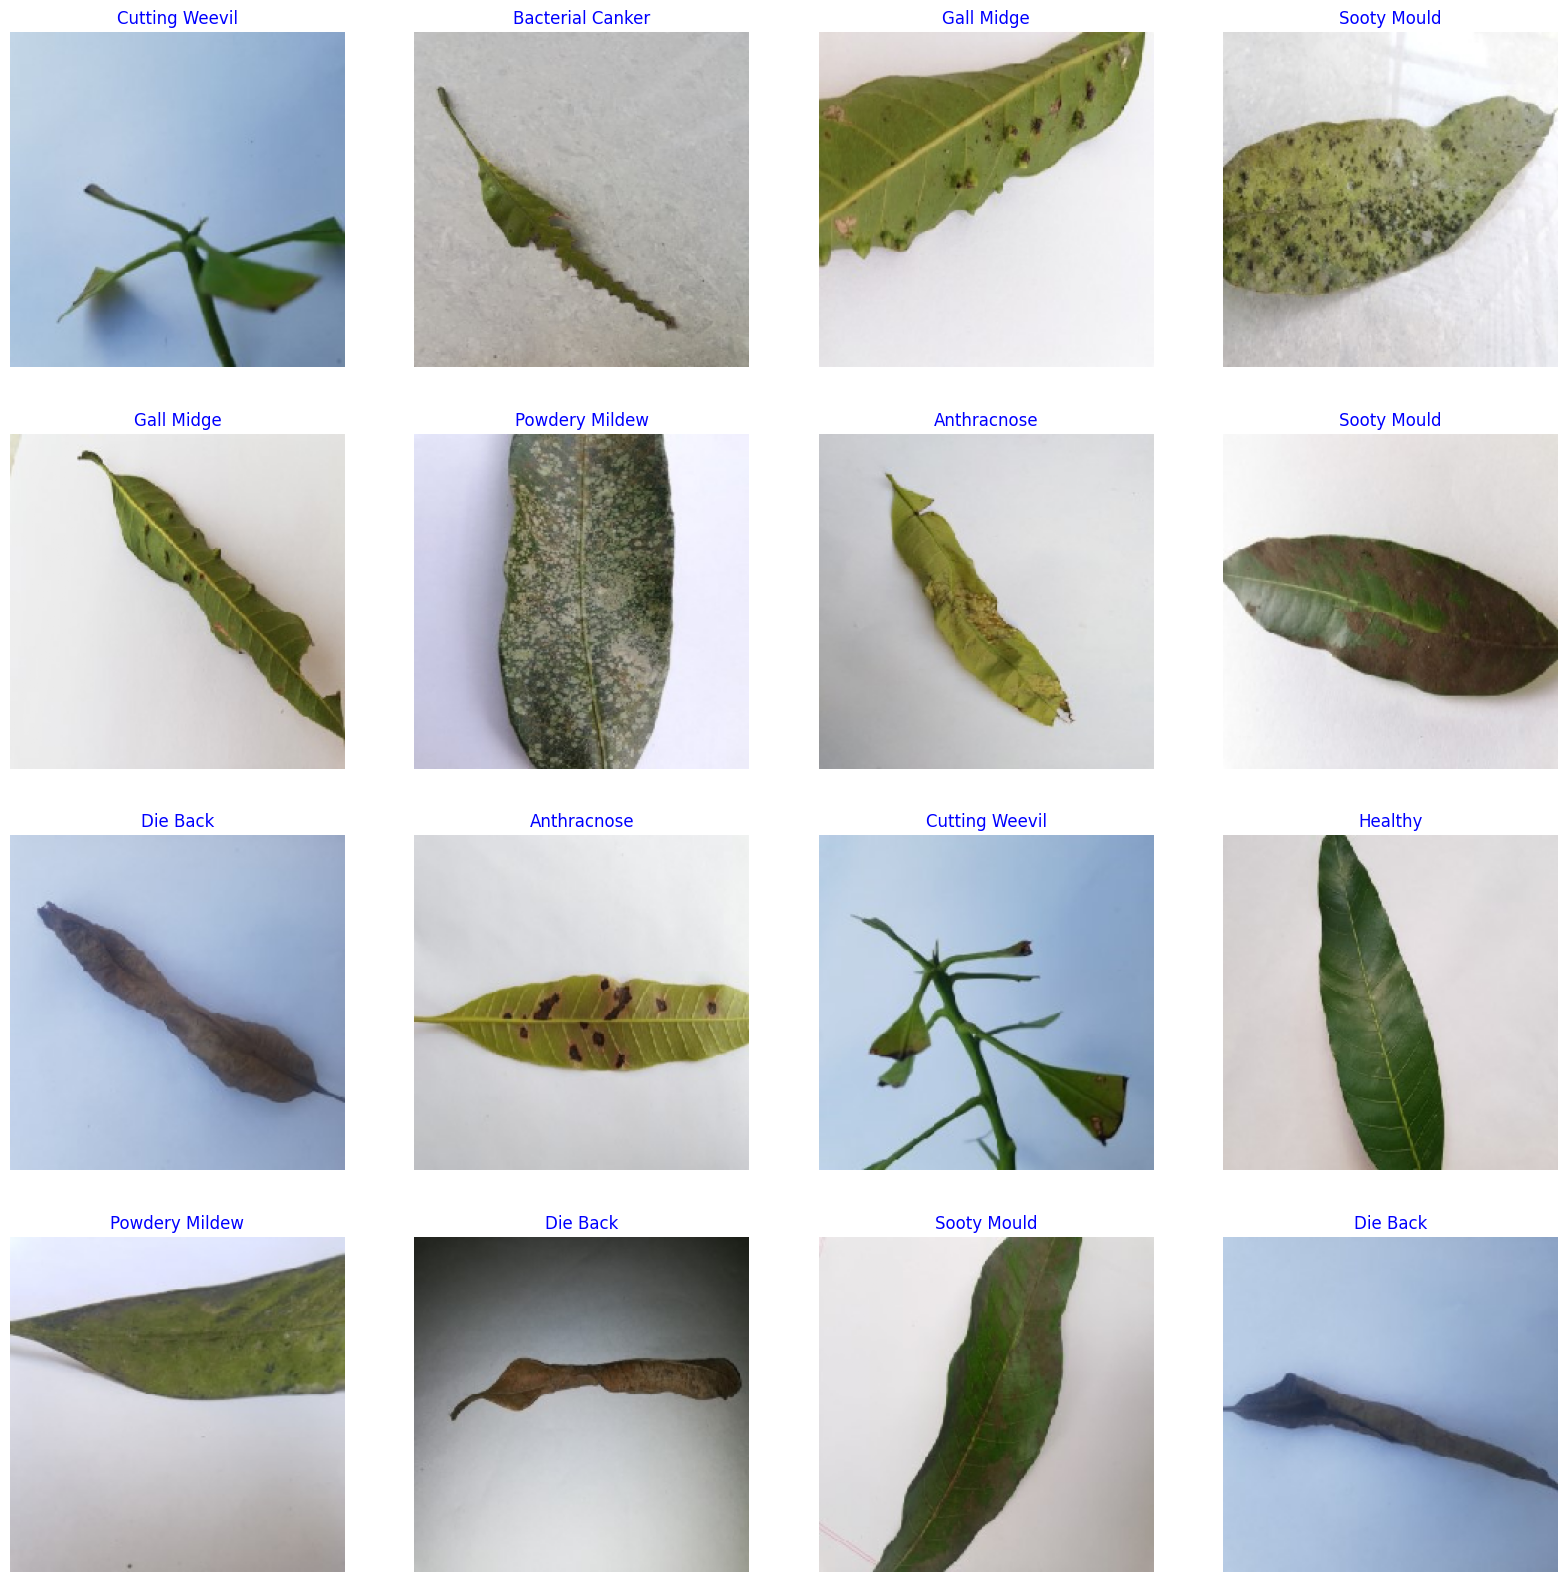

In [10]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [11]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                         

#### **Train model**

In [12]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
200/200 [==============================] - 787s 4s/step - loss: 6.7498 - accuracy: 0.8994 - val_loss: 5.3369 - val_accuracy: 0.9979
Epoch 2/10
200/200 [==============================] - 15s 75ms/step - loss: 4.3743 - accuracy: 0.9850 - val_loss: 3.5388 - val_accuracy: 1.0000
Epoch 3/10
200/200 [==============================] - 15s 74ms/step - loss: 2.9318 - accuracy: 0.9922 - val_loss: 2.3557 - val_accuracy: 0.9958
Epoch 4/10
200/200 [==============================] - 15s 75ms/step - loss: 1.9624 - accuracy: 0.9947 - val_loss: 1.5431 - val_accuracy: 0.9979
Epoch 5/10
200/200 [==============================] - 15s 74ms/step - loss: 1.3068 - accuracy: 0.9959 - val_loss: 1.0293 - val_accuracy: 0.9958
Epoch 6/10
200/200 [==============================] - 15s 74ms/step - loss: 0.8796 - accuracy: 0.9972 - val_loss: 0.6922 - val_accuracy: 1.0000
Epoch 7/10
200/200 [==============================] - 15s 74ms/step - loss: 0.6090 - accuracy: 0.9981 - val_loss: 0.4745 - val_accuracy: 

#### **Display model performance**

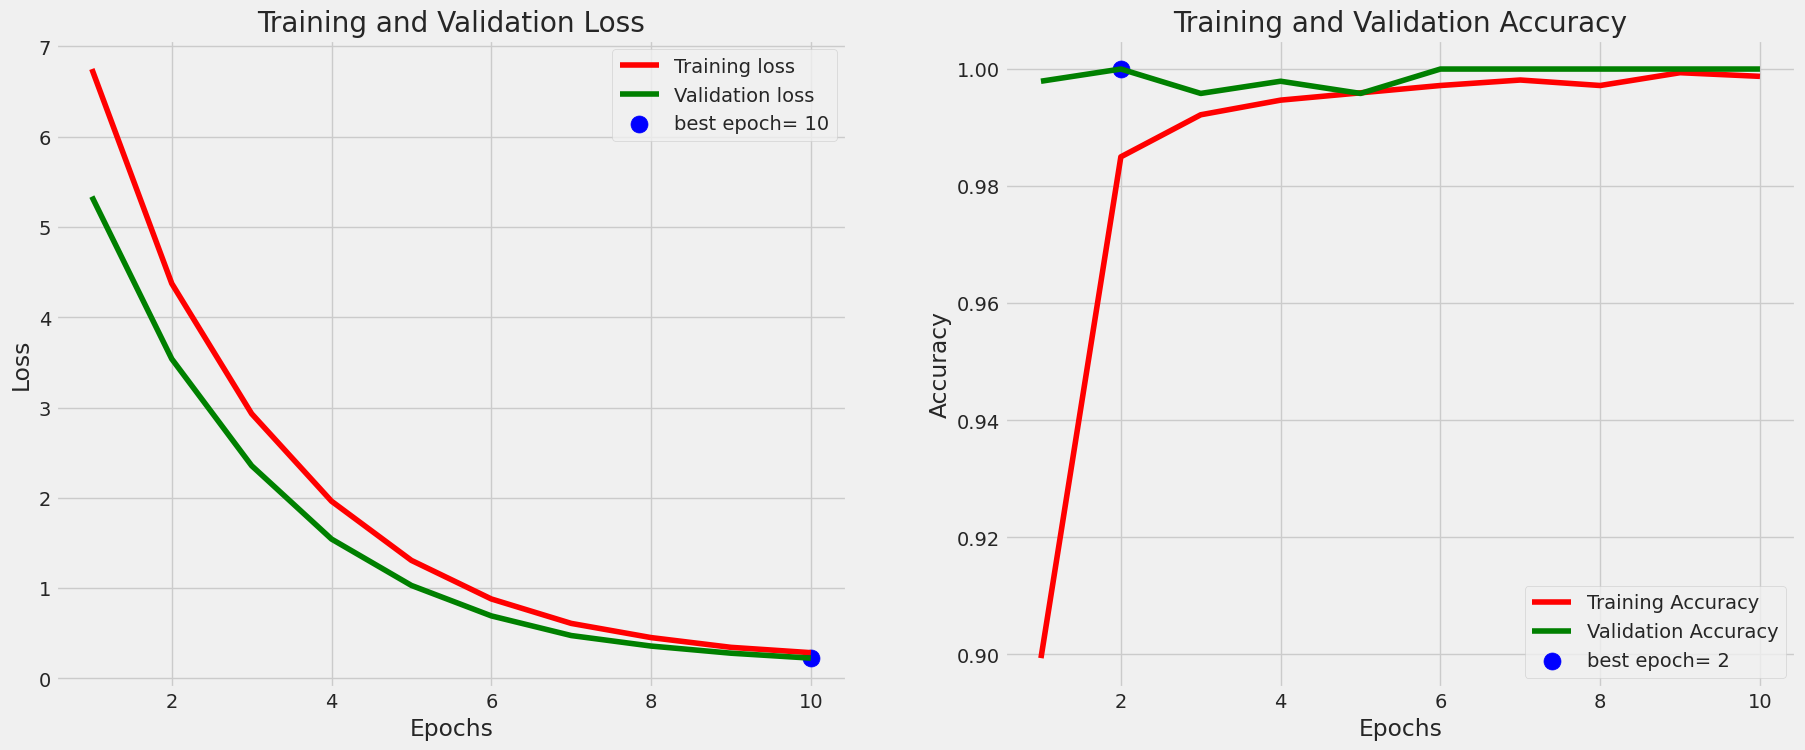

In [20]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [21]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

4/4 [==============================] - 1s 280ms/step - loss: 0.2251 - accuracy: 1.0000
Train Loss:  0.22236713767051697
Train Accuracy:  1.0
--------------------
Validation Loss:  0.223493754863739
Validation Accuracy:  1.0
--------------------
Test Loss:  0.22512421011924744
Test Accuracy:  1.0


# **Get Predictions**

In [22]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

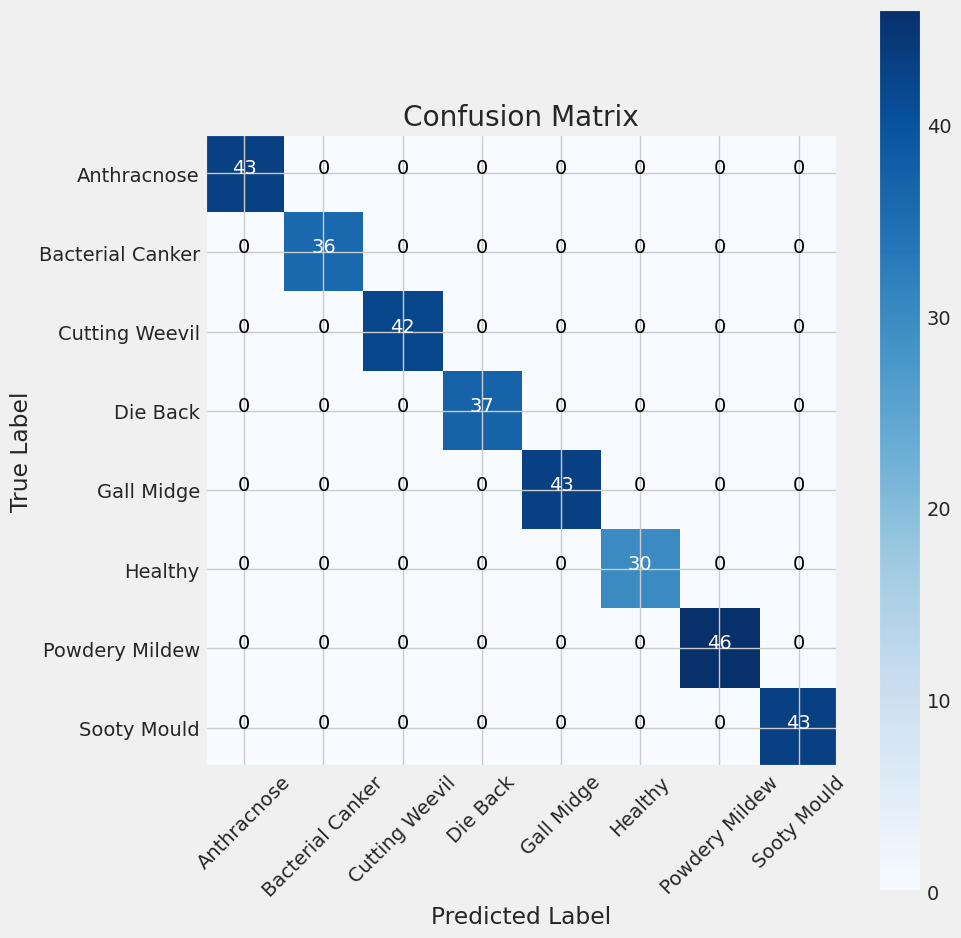

In [23]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [24]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        43
Bacterial Canker       1.00      1.00      1.00        36
  Cutting Weevil       1.00      1.00      1.00        42
        Die Back       1.00      1.00      1.00        37
      Gall Midge       1.00      1.00      1.00        43
         Healthy       1.00      1.00      1.00        30
  Powdery Mildew       1.00      1.00      1.00        46
     Sooty Mould       1.00      1.00      1.00        43

        accuracy                           1.00       320
       macro avg       1.00      1.00      1.00       320
    weighted avg       1.00      1.00      1.00       320



#### **Save model**

In [25]:
model_name = model.input_names[0][:-6]
subject = 'Mango Diseases'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetb0-Mango Diseases-100.00.h5
weights were saved as efficientnetb0-Mango Diseases-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [19]:
# class_dict = train_gen.class_indices
# img_size = train_gen.image_shape
# height = []
# width = []
# for _ in range(len(class_dict)):
#     height.append(img_size[0])
#     width.append(img_size[1])

# Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
# Class_series = pd.Series(list(class_dict.keys()), name= 'class')
# Height_series = pd.Series(height, name= 'height')
# Width_series = pd.Series(width, name= 'width')
# class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
# csv_name = f'{subject}-class_dict.csv'
# csv_save_loc = os.path.join(save_path, csv_name)
# class_df.to_csv(csv_save_loc, index= False)
# print(f'class csv file was saved as {csv_save_loc}')

In [29]:
!pip install streamlit

  Using cached streamlit-1.29.0-py2.py3-none-any.whl (8.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-metadata-7.0.0


In [35]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
#from tensorflow import keras
import random
from PIL import Image, ImageOps
import numpy as np

import warnings
warnings.filterwarnings("ignore")


st.set_page_config(
    page_title="Mango Leaf Disease Detection",
    page_icon = ":mango:",
    initial_sidebar_state = 'auto'
)
hide_streamlit_style = """
            <style>
            #MainMenu {visibility: hidden;}
            footer {visibility: hidden;}
            </style>
            """
st.markdown(hide_streamlit_style, unsafe_allow_html=True)

def prediction_cls(prediction):
    for key, clss in class_names.items():
        if np.argmax(prediction)==clss:

            return key


with st.sidebar:
        st.image('mg.png')
        st.title("Mangifera Healthika")
        st.subheader("Accurate detection of diseases present in the mango leaves. This helps an user to easily detect the disease and identify it's cause.")


@st.cache(allow_output_mutation=True)
def load_model():
    model=tf.keras.models.load_model('mango_model.h5')
    return model
with st.spinner('Model is being loaded..'):
    model=load_model()
    #model = keras.Sequential()
    #model.add(keras.layers.Input(shape=(224, 224, 4)))


st.write("""
         # Mango Disease Detection with Remedy Suggestion
         """
         )

file = st.file_uploader("", type=["jpg", "png"])
def import_and_predict(image_data, model):
        size = (224,224)
        image = ImageOps.fit(image_data, size, Image.Resampling.LANCZOS)
        img = np.asarray(image)
        img_reshape = img[np.newaxis,...]
        prediction = model.predict(img_reshape)
        return prediction


if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    x = random.randint(98,99)+ random.randint(0,99)*0.01
    st.sidebar.error("Accuracy : " + str(x) + " %")

    class_names = ['Anthracnose', 'Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']

    string = "Detected Disease : " + class_names[np.argmax(predictions)]
    if class_names[np.argmax(predictions)] == 'Healthy':
        st.balloons()
        st.sidebar.success(string)

    elif class_names[np.argmax(predictions)] == 'Anthracnose':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Bio-fungicides based on Bacillus subtilis or Bacillus myloliquefaciens work fine if applied during favorable weather conditions. Hot water treatment of seeds or fruits (48°C for 20 minutes) can kill any fungal residue and prevent further spreading of the disease in the field or during transport.")

    elif class_names[np.argmax(predictions)] == 'Bacterial Canker':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Prune flowering trees during blooming when wounds heal fastest. Remove wilted or dead limbs well below infected areas. Avoid pruning in early spring and fall when bacteria are most active.If using string trimmers around the base of trees avoid damaging bark with breathable Tree Wrap to prevent infection.")

    elif class_names[np.argmax(predictions)] == 'Cutting Weevil':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Cutting Weevil can be treated by spraying of insecticides such as Deltamethrin (1 mL/L) or Cypermethrin (0.5 mL/L) or Carbaryl (4 g/L) during new leaf emergence can effectively prevent the weevil damage.")

    elif class_names[np.argmax(predictions)] == 'Die Back':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("After pruning, apply copper oxychloride at a concentration of '0.3%' on the wounds. Apply Bordeaux mixture twice a year to reduce the infection rate on the trees. Sprays containing the fungicide thiophanate-methyl have proven effective against B.")

    elif class_names[np.argmax(predictions)] == 'Gall Midge':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("Use yellow sticky traps to catch the flies. Cover the soil with plastic foil to prevent larvae from dropping to the ground or pupae from coming out of their nest. Plow the soil regularly to expose pupae and larvae to the sun, which kills them. Collect and burn infested tree material during the season.")


    elif class_names[np.argmax(predictions)] == 'Powdery Mildew':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("In order to control powdery mildew, three sprays of fungicides are recommended. The first spray comprising of wettable sulphur (0.2%, i.e., 2g per litre of water) should be done when the panicles are 8 -10 cm in size as a preventive spray.")

    elif class_names[np.argmax(predictions)] == 'Sooty Mould':
        st.sidebar.warning(string)
        st.markdown("## Remedy")
        st.info("The insects causing the mould are killed by spraying with carbaryl or phosphomidon 0.03%. It is followed by spraying with a dilute solution of starch or maida 5%. On drying, the starch comes off in flakes and the process removes the black mouldy growth fungi from different plant parts.")




Writing app.py


In [38]:
!pip install pyngrok

In [39]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2023-12-14 04:25:31--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 52.202.168.65, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  40.9MB/s    in 0.3s    

2023-12-14 04:25:32 (40.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]



In [40]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [41]:
get_ipython().system_raw('./ngrok http 8501 &')

In [42]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.10/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [43]:
!streamlit run /content/drive/MyDrive/MLDP/app.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.202.76.38:8501

  Stopping...
  Stopping...
